In [ ]:
#Install needed modules
!pip install kagglehub

In [ ]:
from IPython import get_ipython
from IPython.display import display
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers as tf_layers #Import layers as tf_layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
import kagglehub
from tensorflow.keras import layers
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(ex)

[]


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:12<00:00, 64.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [ ]:
# Use the downloaded path
data_dir_train = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Train/") # correct directory
data_dir_test = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Test/") #correct directory

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


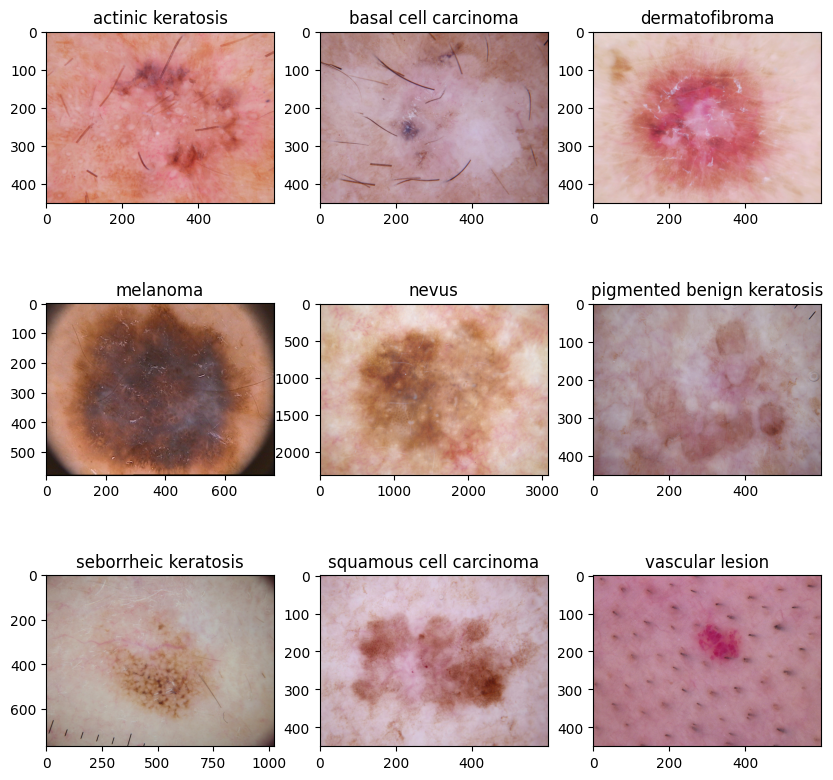

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 9
# Remove layers.experimental and access Rescaling directly through layers.preprocessing
model = Sequential([layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))])

model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# We have updated the rest of the keras calls to use tf.keras

In [ ]:
# We will correct the instantiation of the Adam optimizer
# Instead of opt = Adam(lr=0.001) use opt = Adam(learning_rate=0.001)
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.2065 - loss: 2.0783 - val_accuracy: 0.2707 - val_loss: 1.9029
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.2871 - loss: 1.8726 - val_accuracy: 0.4318 - val_loss: 1.6470
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.3948 - loss: 1.6641 - val_accuracy: 0.3691 - val_loss: 1.7267
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.4448 - loss: 1.5597 - val_accuracy: 0.4116 - val_loss: 1.6346
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.4743 - loss: 1.4805 - val_accuracy: 0.5078 - val_loss: 1.4799
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.5262 - loss: 1.3558 - val_accuracy: 0.4720 - val_loss: 1.4727
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.5202 - loss: 1.3428 - val_accuracy: 0.5034 - val_loss: 1.3878
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.5609 - loss: 1.2568 - val_accuracy: 0.4944 - v

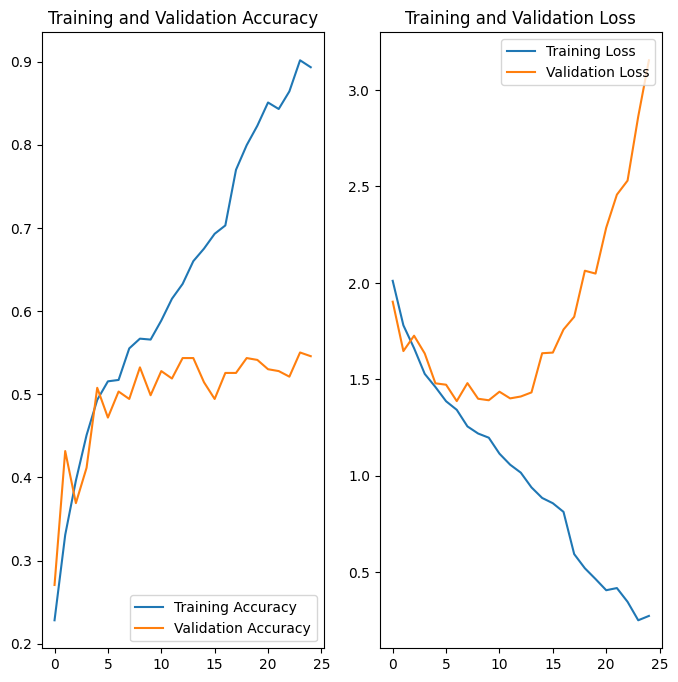

In [ ]:
# We now have the history variable, we will plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf_layers.RandomFlip("horizontal_and_vertical", #Corrected layers.experimental.preprocessing to tf_layers
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    tf_layers.RandomRotation(0.2), #Corrected layers.experimental.preprocessing to tf_layers
    tf_layers.RandomZoom(0.2), #Corrected layers.experimental.preprocessing to tf_layers
  ]
)

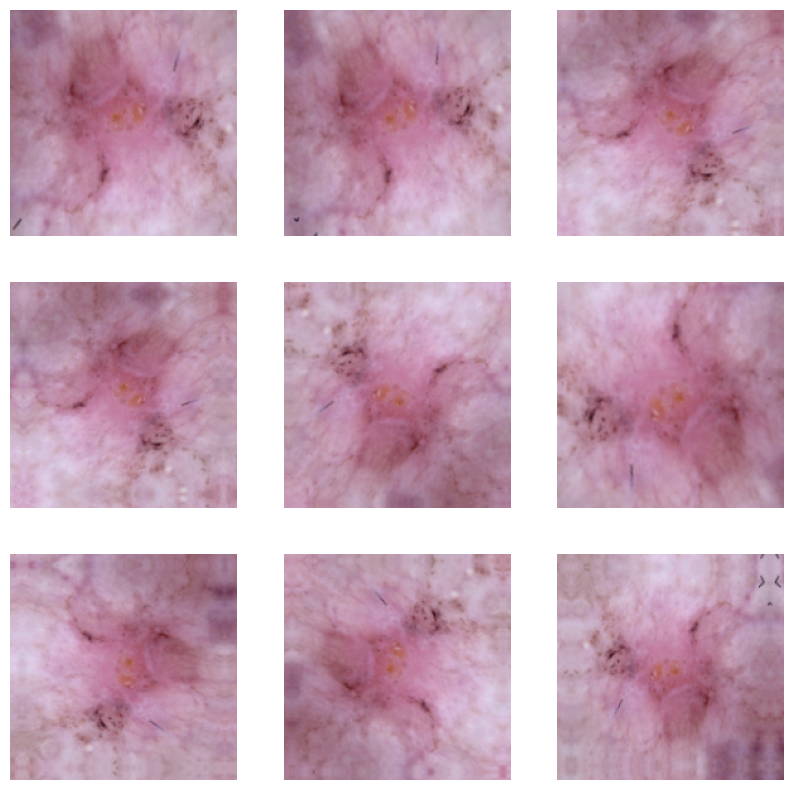

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 9
# Create the model
model = Sequential()
# Add data augmentation as the first layer.
model.add(data_augmentation)
# Add the rest of the layers
model.add(tf_layers.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
#Change opt = Adam(lr=0.001) to opt = Adam(learning_rate=0.001)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.1831 - loss: 2.1801 - val_accuracy: 0.2729 - val_loss: 1.9666
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.2782 - loss: 1.8782 - val_accuracy: 0.3199 - val_loss: 1.9051
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.3318 - loss: 1.8072 - val_accuracy: 0.4318 - val_loss: 1.6355
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.4111 - loss: 1.6238 - val_accuracy: 0.4497 - val_loss: 1.5965
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.4461 - loss: 1.5355 - val_accuracy: 0.5011 - val_loss: 1.5244
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.4588 - loss: 1.5118 - val_accuracy: 0.4765 - val_loss: 1.5333
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.4981 - loss: 1.4356 - val_accuracy: 0.4944 - val_loss: 1.4984
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.4927 - loss: 1.4137 - val_accuracy: 0.5123 - v

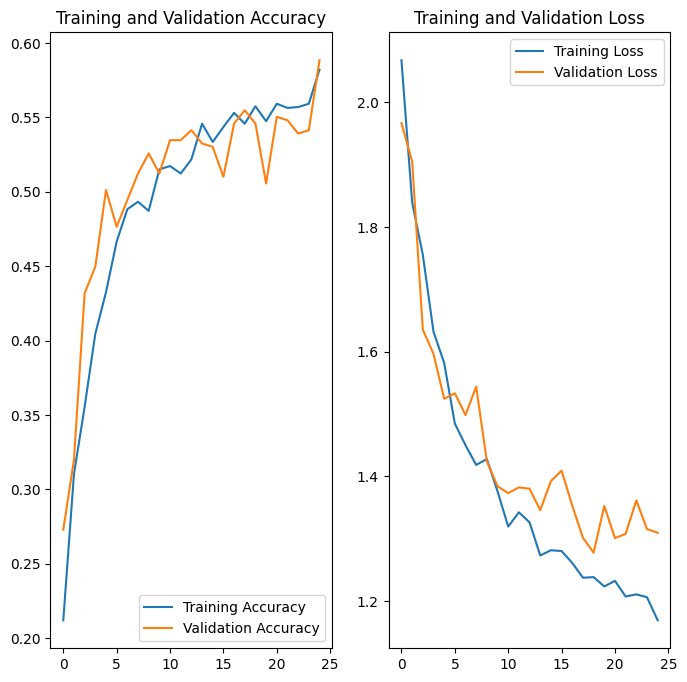

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

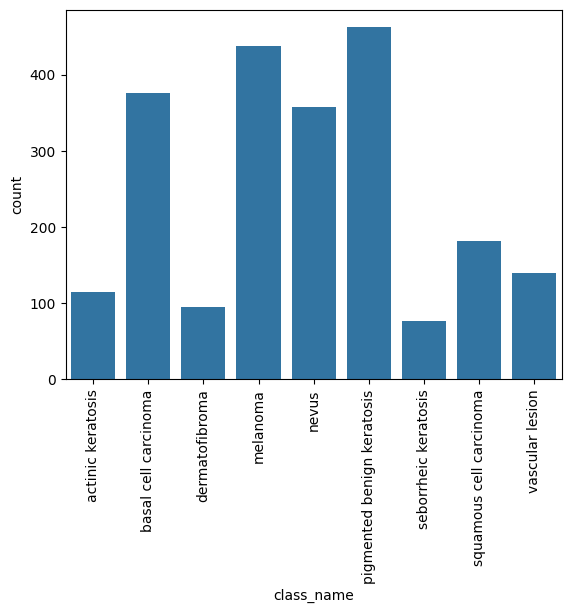

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install Augmentor

In [ ]:
# Install Augmentor if not already installed.
!pip install Augmentor

import Augmentor
import os
import pathlib

# Set the correct training data directory.
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
data_dir_train = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

# Create a directory to store the augmented images if it does not already exist.
# This directory will be in your working directory, as opposed to the original input directory
# that cannot be modified.
for class_name in class_names:
    os.makedirs('/kaggle/working/data/' + class_name + '/output/', exist_ok=True)

# Iterate over the class names and create an augmentation pipeline for each.
for class_name in class_names:
    # Construct the path to each class
    class_path = data_dir_train / class_name

    # Create the pipeline for the class.
    p = Augmentor.Pipeline(str(class_path), output_directory='/kaggle/working/data/' + class_name + '/output/')
    # Apply transformations as needed.
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CDE40D86CD0>: 100%|██████████| 1000/1000 [00:41<00:00, 23.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CDE4107DAD0>: 100%|██████████| 1000/1000 [00:34<00:00, 29.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CDE4102D250>: 100%|██████████| 1000/1000 [00:34<00:00, 29.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7CDE41469850>: 100%|██████████| 1000/1000 [02:59<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CDE413A5B90>: 100%|██████████| 1000/1000 [02:46<00:00,  6.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CDE41218910>: 100%|██████████| 1000/1000 [00:31<00:00, 32.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CDE413C52D0>: 100%|██████████| 1000/1000 [01:16<00:00, 13.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CDE413AFCD0>: 100%|██████████| 1000/1000 [00:31<00:00, 31.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CDE414C6050>: 100%|██████████| 1000/1000 [00:32<00:00, 30.78 Samples/s]


In [ ]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

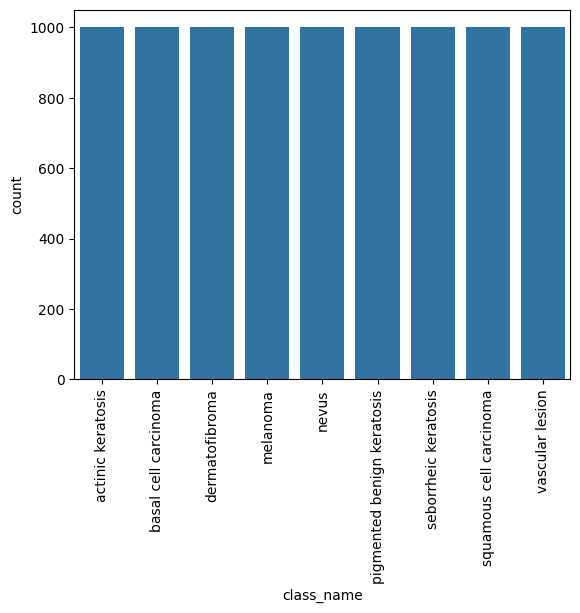

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install Augmentor
import Augmentor
import os
import pathlib
import tensorflow as tf
import kagglehub

# ... (other code) ...

# Set the correct training data directory.
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
data_dir_train = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

# Load the training dataset to define class_names
# This should be done before the loop to ensure class_names is defined
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names  # Assign class names here

# Create a directory to store the augmented images if it does not already exist.
# This directory will be in your working directory, as opposed to the original input directory
# that cannot be modified.
output_dir = pathlib.Path('/kaggle/working/data/')  # Correct the output directory
for class_name in class_names:
    os.makedirs(output_dir / class_name, exist_ok=True)

# Iterate over the class names and create an augmentation pipeline for each.
for class_name in class_names:
    # Construct the path to each class
    class_path = data_dir_train / class_name

    # Create the pipeline for the class, correcting the output directory
    p = Augmentor.Pipeline(str(class_path), output_directory=str(output_dir / class_name))
    # Apply transformations as needed.
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

# ... (rest of your code) ...

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,  # This should now point to the correct directory
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

100%|██████████| 786M/786M [00:09<00:00, 85.2MB/s]

Extracting files...


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791D306D91D0>: 100%|██████████| 1000/1000 [00:35<00:00, 28.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791D3422CD10>: 100%|██████████| 1000/1000 [00:34<00:00, 29.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791D30652AD0>: 100%|██████████| 1000/1000 [00:34<00:00, 28.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x791D305AF310>: 100%|██████████| 1000/1000 [02:53<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x791D3422CAD0>: 100%|██████████| 1000/1000 [02:53<00:00,  5.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791D3376A090>: 100%|██████████| 1000/1000 [00:33<00:00, 30.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x791D3487BBD0>: 100%|██████████| 1000/1000 [01:24<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791D34248F50>: 100%|██████████| 1000/1000 [00:32<00:00, 30.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791D30602F90>: 100%|██████████| 1000/1000 [00:33<00:00, 29.95 Samples/s]


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define img_height and img_width
img_height = 180
img_width = 180

num_classes = 9

# Remove layers.experimental and access Rescaling directly through layers.preprocessing
model = Sequential([tf.keras.layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))])

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Change opt = Adam(lr=0.001) to opt = Adam(learning_rate=0.001)
# Adam is now imported, so it should be accessible
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Use tf.keras.losses for SparseCategoricalCrossentropy
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 ━━━━━━━━━━━━━━━━━━━━ 981s 4s/step - accuracy: 0.1561 - loss: 2.1025 - val_accuracy: 0.3600 - val_loss: 1.6768
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 956s 4s/step - accuracy: 0.3957 - loss: 1.5105 - val_accuracy: 0.4700 - val_loss: 1.3894
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.4911 - loss: 1.3551 - val_accuracy: 0.5228 - val_loss: 1.2385
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 968s 4s/step - accuracy: 0.5254 - loss: 1.2326 - val_accuracy: 0.5939 - val_loss: 1.1068
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 987s 4s/step - accuracy: 0.5997 - loss: 1.0515 - val_accuracy: 0.6489 - val_loss: 0.9510
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 991s 4s/step - accuracy: 0.6518 - loss: 0.9145 - val_accuracy: 0.6694 - val_loss: 0.9021
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 967s 4s/step - accuracy: 0.7039 - loss: 0.7838 - val_accuracy: 0.7339 - val_loss: 0.7262
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.7595 - loss: 0.6532 - val_accuracy: 0.790

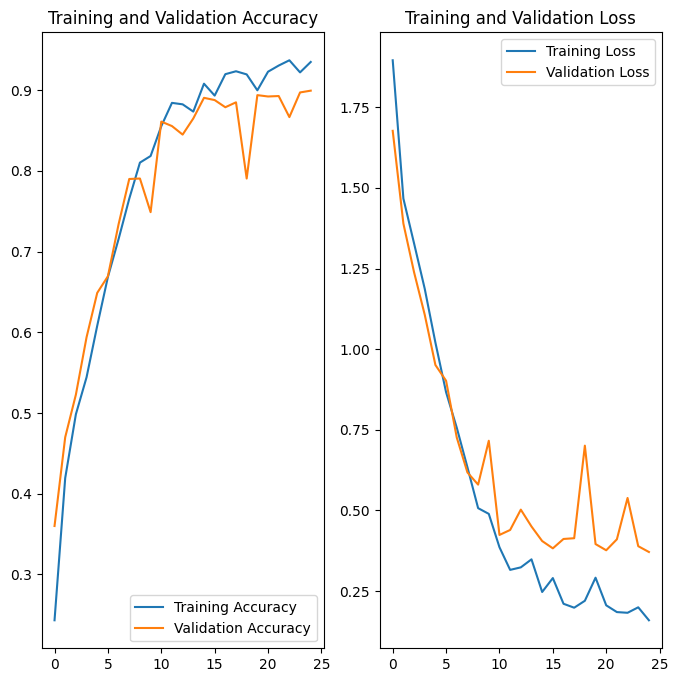

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Create a file to save models
#correct file name
top_model_weights_path = '/kaggle/working/cnn_fc_model.weights.h5'
model.save_weights(top_model_weights_path)

In [ ]:
import tensorflow as tf
import pathlib
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

# Define dataset paths using the downloaded path
data_dir_train = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Test/") # Define data_dir_test here

# ... (Rest of the code to load and process the test dataset) ...
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# You can access the images and labels from the test_ds using a loop
for images, labels in test_ds:
    # Process the images and labels here
    # For example, you can print their shapes:
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1
Found 118 files belonging to 9 classes.
Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, verbose=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3846 - loss: 5.6744


In [ ]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

[INFO] accuracy: 40.68%
[INFO] Loss: 6.382481098175049


In [ ]:
import tensorflow as tf
import pathlib
import random

In [ ]:
# Define dataset paths
data_dir_train = pathlib.Path("/path/to/your/train/dataset")  # Update this path
data_dir_test = pathlib.Path("/path/to/your/test/dataset")    # Update this path


In [ ]:
# Set parameters
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [ ]:
import kagglehub
import pathlib
# ... (rest of the code) ...

In [ ]:
# Download latest version (make sure this is in the same cell where it's used)
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [ ]:
# Define dataset paths using the downloaded path
data_dir_train = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")
# ... (rest of the code) ...

In [ ]:
# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
 #Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [ ]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Import necessary libraries
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam


In [ ]:
# Define the model architecture
model = Sequential([
    Rescaling(1.0/255, input_shape=(180, 180, 3)),  # Normalize pixel values

    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPool2D(),

    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Dropout(0.15),

    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Dropout(0.20),

    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation="relu"),
    Dense(9, activation='softmax')  # Replace len(class_names) with actual number of classes (9)
])


In [ ]:
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save the model to a file using joblib
joblib.dump(model, 'melanoma_model.pkl')

['melanoma_model.pkl']

In [ ]:
model.save('melanoma_model.h5')  # or use .keras extension


In [ ]:
model.save('melanoma_model.keras')


In [ ]:
from tensorflow.keras.models import load_model
# Load the model using the correct filename 'melanoma_model_saved.keras'
model = load_model("melanoma_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.save("melanoma_model_saved.keras") # Add .keras or .h5 extension to the file name

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("melanoma_model_saved.keras") # Add .keras extension to the file name


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
import kagglehub
import pathlib # Import the pathlib module

# Load the saved model
model = load_model("melanoma_model_saved.keras")

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)
data_dir_test = pathlib.Path(path + "/Skin cancer ISIC The International Skin Imaging Collaboration/Test/") #correct directory

# Define parameters
batch_size = 32
img_height = 180
img_width = 180

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1
Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.0847 - loss: 2.1959
Test Accuracy: 0.08


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/melanoma_model_saved.keras')


In [ ]:
from google.colab import files
files.download("melanoma_model_saved.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>